In [1]:
import keras

Using Theano backend.
Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 5103)
/home/joakim/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
#path = "data/sample/"
path = "data/"
model_path = "model/second/"
batch_size=10

In [3]:
import utils; reload(utils)
from utils import *
import bcolz
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division, print_function
from keras.layers import Input, Dense
from keras.models import Model

I'll begin by making a sample of our dataset, so we can iterate over solutions more quickly than otherwise.

Doing a full pass of the training-data with a 80/20 split on my GTX 970 takes around 6-8 minutes, which is too long to actually experiment.

In [4]:
%ls

cats_vs_dogs_redux_first.ipynb   data/     utils.py*  vgg16bn.py*  vgg16.py*
cats_vs_dogs_redux_second.ipynb  results/  utils.pyc  vgg16bn.pyc  vgg16.pyc


In [14]:
import os, sys
%cd data
DATA_HOME_DIR = os.getcwd()
print(DATA_HOME_DIR)

/home/joakim/projects/KaggleDogsCatsRedux/data
/home/joakim/projects/KaggleDogsCatsRedux/data


In [7]:
%cd DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/joakim/projects/KaggleDogsCatsRedux/data


In [30]:
from shutil import copyfile
def execute_on_random_jpgs(directory, method, num_files):
    g = glob('*.jpg')
    shuf = np.random.permutation(g)
    for i in range(num_files): method(shuf[i], '{}/{}'.format(directory, shuf[i]))

In [31]:
%cd $DATA_HOME_DIR/train/
#commented out to make sure I don't execute this several times by mistake
#execute_on_random_jpgs('{}/{}'.format(DATA_HOME_DIR, 'valid'), os.rename, 2000)

/home/joakim/projects/KaggleDogsCatsRedux/data/train


In [32]:
%cd $DATA_HOME_DIR/train/
#execute_on_random_jpgs('{}/{}'.format(DATA_HOME_DIR, 'sample/train'), copyfile, 250)
#execute_on_random_jpgs('{}/{}'.format(DATA_HOME_DIR, 'sample/valid'), copyfile, 75)

/home/joakim/projects/KaggleDogsCatsRedux/data/train


In [36]:
def move_dogs_cats(directory):
    %cd $directory
    %mkdir cats
    %mkdir dogs
    %mv cat.*.jpg cats/
    %mv dog.*.jpg dogs/

In [37]:
move_dogs_cats(DATA_HOME_DIR+"/sample/train")
move_dogs_cats(DATA_HOME_DIR+"/sample/valid")
move_dogs_cats(DATA_HOME_DIR+"/valid")
move_dogs_cats(DATA_HOME_DIR+"/train")

/home/joakim/projects/KaggleDogsCatsRedux/data/sample/train
mkdir: cannot create directory ‘cats’: File exists
mkdir: cannot create directory ‘dogs’: File exists
mv: cannot stat 'cat.*.jpg': No such file or directory
mv: cannot stat 'dog.*.jpg': No such file or directory
/home/joakim/projects/KaggleDogsCatsRedux/data/sample/valid
/home/joakim/projects/KaggleDogsCatsRedux/data/valid
/home/joakim/projects/KaggleDogsCatsRedux/data/train


In [38]:
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

/home/joakim/projects/KaggleDogsCatsRedux/data/test


In [44]:
%cd ../..

/home/joakim/projects/KaggleDogsCatsRedux


In [4]:
size=(400,400)
batches = get_batches(path+'train', batch_size=batch_size, target_size=size)
val_batches = get_batches(path+'valid', batch_size=batch_size, shuffle=False, target_size=size)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [16]:
imgs,labels = next(batches)

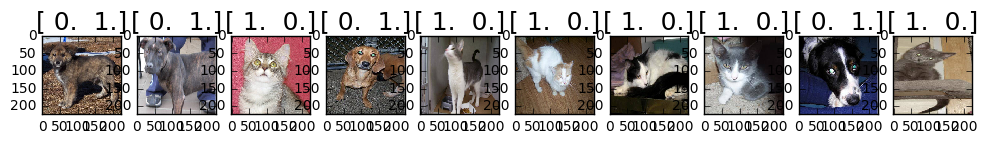

In [17]:
plots(imgs, titles=labels)

In [5]:
from vgg16bn import Vgg16BN
vgg = Vgg16BN(size)
model = vgg.model
model.pop()

/home/joakim/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 400, 400)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [6]:
model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
#                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 400, 400)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 402, 402)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 400, 400)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 402, 402)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [9]:
conv_layers,_ = split_at(model, Convolution2D)

In [10]:
# Pop off enough layers that only convolutions remain.
for i in range(8):
    model.pop()

In [7]:
nf=128; p=0.

In [8]:
#Set all layers to trainable=False, to freeze the top part of the model
for layer in model.layers: layer.trainable=False

In [9]:
lrg_model = Sequential()
lrg_model.add(model)
lrg_model.add(BatchNormalization(axis=1))
lrg_model.add(Convolution2D(nf,3,3, activation='relu', border_mode='same'))
lrg_model.add(BatchNormalization(axis=1))
lrg_model.add(MaxPooling2D())
lrg_model.add(Convolution2D(nf,3,3, activation='relu', border_mode='same'))
lrg_model.add(BatchNormalization(axis=1))
lrg_model.add(MaxPooling2D())
lrg_model.add(Convolution2D(nf,3,3, activation='relu', border_mode='same'))
lrg_model.add(BatchNormalization(axis=1))
lrg_model.add(MaxPooling2D((1,2)))
lrg_model.add(Convolution2D(2,3,3, border_mode='same'))
lrg_model.add(Dropout(p))
lrg_model.add(GlobalAveragePooling2D())
lrg_model.add(Activation('softmax'))

In [10]:
lrg_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
sequential_1 (Sequential)        (None, 512, 25, 25)   14714688                                     
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 512, 25, 25)   2048        convolution2d_13[0][0]           
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 128, 25, 25)   589952      batchnormalization_1[0][0]       
____________________________________________________________________________________________________
batchnormalization_2 (BatchNorma (None, 128, 25, 25)   512         convolution2d_14[0][0]           
___________________________________________________________________________________________

In [11]:
lrg_model.compile(optimizer=Adam(1e-3),
       loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
lrg_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
23000/23000 [==============================] - 1403s - loss: 0.0868 - acc: 0.9656 - val_loss: 0.0411 - val_acc: 0.9875

In [13]:
model.save_weights(path+'results/fully_convolutional_400.h5')

In [14]:
test_batches = get_batches(path+'test', batch_size=batch_size, target_size=size)

Found 12500 images belonging to 1 classes.


In [15]:
preds = lrg_model.predict_generator(test_batches, 12500)

## Submit data
We're ready to submit our data to Kaggle, and will use these lines of codes to generate our submission.

In [16]:
isdog = preds[:,1]
isdog = isdog.clip(min=0.05, max=0.95)

In [17]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = test_batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [18]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  4.0680e+03,   5.0000e-02],
       [  5.9930e+03,   5.0000e-02],
       [  3.6040e+03,   5.0000e-02],
       [  7.2650e+03,   9.5000e-01],
       [  5.8700e+03,   5.0000e-02]])

In [19]:
submission_file_name = path + 'results/submission_fully_cnn.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')